In [1]:
import os
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from Classfile import *
from pre_processing import create_df

main = "/Users/alena/Library/CloudStorage/OneDrive-Personal/Work/PhD/Isochrone_Archive/Coding/"
subdir = date.today()
output_path = os.path.join(main, str(subdir))
try:
    os.mkdir(output_path)
except FileExistsError:
    pass
output_path = output_path + "/"

In [2]:
data_path = "/Users/alena/PycharmProjects/PaperI/"

In [3]:
CI_raw = data_path +"data/Cluster_data/all_ages/CatalogI_BCD_ages.csv"

CI_cols = ["Cluster", "Plx", "e_Plx", "Gmag", "e_Gmag", "BPmag", "e_BPmag", "RPmag", "e_RPmag", "BP-RP", "BP-G",
           "G-RP",
           "logA_B", "AV_B", "AgeNN_CG", "AVNN_CG", "logage_D", "Av_D",
           "RUWE", "Proba"]

CI_names = ["Cluster_id", "plx", "e_plx", "Gmag", "e_Gmag", "BPmag", "e_BPmag", "RPmag", "e_RPmag", "BP-RP", "BP-G",
            "G-RP",
            "age_B", "av_B", "age_C", "av_C", "age_D", "av_D", "ruwe", "probability"]

q_filter = {"parameter": ["ruwe", "plx", "probability"], "limit": ["upper", "lower", "lower"], "value": [1.4, 0, 0.49]}

CI_clusters, CI_df = create_df(CI_raw, CI_cols, CI_names, q_filter)

CI_df["ref_age"] = CI_df["age_C"]

In [4]:
OC = star_cluster(CI_clusters[0], CI_df)

OC.create_CMD() # ok they are scaled

pca_arr = OC.PCA_XY
params = OC.SVR_Hyperparameter_tuning(array = pca_arr, weight_data= OC.weights)
# params = params_all_Archive[j]

svr = SVR(**params)

svr_predict = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)

X = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)
Y = pca_arr[:, 1]

Y_all_unweighted = svr.fit(X, Y).predict(svr_predict)
SVR_all_u = np.stack([svr_predict[:, 0], Y_all_unweighted], 1)
SVR_all_u = SVR_all_u[SVR_all_u[:, 0].argsort()]
rev_transform_u = OC.pca.inverse_transform(SVR_all_u)

Y_all_weighted= svr.fit(X, Y, sample_weight=OC.weights).predict(svr_predict)
SVR_all_w = np.stack([svr_predict[:, 0], Y_all_weighted], 1)
SVR_all_w = SVR_all_w[SVR_all_w[:, 0].argsort()]
rev_transform_w = OC.pca.inverse_transform(SVR_all_w)

fin
{'C': 8.858667904100823, 'epsilon': 0.03162277660168379, 'gamma': 'scale', 'kernel': 'rbf'}
score: 0.3444799168471534
std: 0.24239727473873876


/var/folders/z6/y4rdkpdx3vlbwtmngx04x_1w0000gp/T/ipykernel_17992/2641095177.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


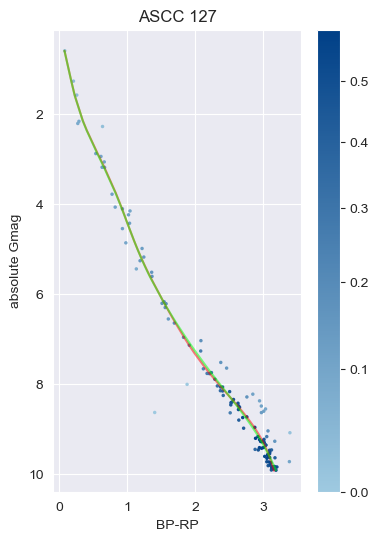

In [5]:
f = CMD_density_design(OC.CMD, cluster_obj=OC)
OC.kwargs_CMD["s"] = 50
plt.plot(rev_transform_u[:, 0], rev_transform_u[:, 1], color="red", alpha = 0.5)
plt.plot(rev_transform_w[:, 0], rev_transform_w[:, 1], color="lime", alpha = 0.5)
f.show()
#f.savefig(output_path + "{}_weights.pdf".format(OC.name), dpi=500)

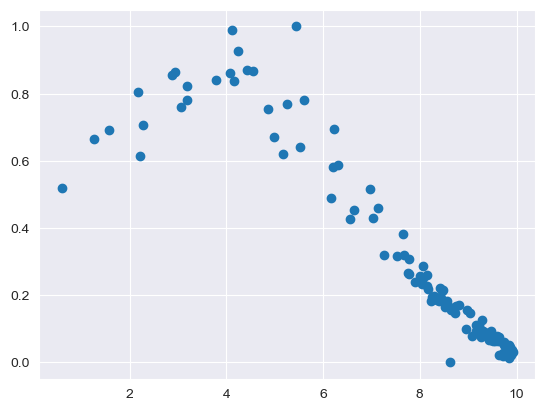

In [6]:
plt.scatter(OC.CMD[:,1], OC.weights)

In [8]:
OC.CMD_specs = dict(axes=["Gmag", "BP-RP"], filters=["Gmag", "BPmag", "RPmag"])
CMD_params = OC.CMD_specs["axes"]
mag, cax = OC.data[CMD_params[0]], OC.data[CMD_params[1]]
abs_mag = (mag - 5 * np.log10(OC.distance) + 5)

arr = np.stack([cax, abs_mag], axis=1)
# first remove nans
nan_idxes = np.isnan(arr).any(axis=1)
cleaned_arr = arr[~nan_idxes]
# then sort the array along the y axis
sort_idxes = cleaned_arr[:, 1].argsort()
sorted_arr = cleaned_arr[sort_idxes]

# errors
CMD_errors_nonan = OC.errors[~nan_idxes]
CMD_error_values = CMD_errors_nonan.values
CMD_errors = pd.DataFrame(CMD_error_values[sort_idxes], CMD_errors_nonan.index[sort_idxes],
                          CMD_errors_nonan.columns)

CMD_plx_nonan = OC.data["plx"][~nan_idxes].to_numpy()
CMD_plx = CMD_plx_nonan[sort_idxes]

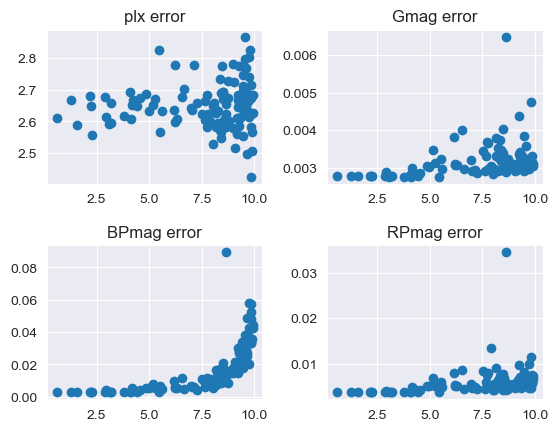

In [10]:
error_fig = plt.figure()

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))

ax1.scatter(OC.CMD[:,0], CMD_plx)
ax1.set_title("plx error")
ax2.scatter(OC.CMD[:,0], CMD_errors["e_Gmag"])
ax2.set_title("Gmag error")
ax3.scatter(OC.CMD[:,0], CMD_errors["e_BPmag"])
ax3.set_title("BPmag error")
ax4.scatter(OC.CMD[:,0], CMD_errors["e_RPmag"])
ax4.set_title("RPmag error")

plt.subplots_adjust(hspace =0.4,wspace = 0.3)